# ResNet-18: CIFAR-10 + ```albumentations``` + PyTorch

CNN trained from scratch with ```albumentations``` assisted data augmentations.

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
'''
Specify GPU(s) to be used here. Say you have 6 GPUs and you want to train Model A on 2 of them
and Model B on 4 of them. You can do that as follows-
CUDA_VISIBLE_DEVICES=0,1 python model_A.py
CUDA_VISIBLE_DEVICES=2,3,4,5 python model_B.py
'''
# %env CUDA_VISIBLE_DEVICES = 0, 1, 2, 3
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
# import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, pickle
import albumentations as A
from albumentations.pytorch import ToTensorV2

/home/majumdar/anaconda3/envs/torch-gpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/majumdar/anaconda3/envs/torch-gpu/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/majumdar/anaconda3/envs/torch-gpu/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

torch version: 1.13.0+cu117
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce GTX TITAN X


In [4]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Specify hyper-parameters
batch_size = 256
num_classes = 10
num_epochs = 80

In [8]:
# Define transformations using albumentations-
transform_train = A.Compose(
    [
        # A.Resize(width = 32, height = 32),
        # A.RandomCrop(width = 20, height = 20),
        A.Rotate(limit = 40, p = 0.9, border_mode = cv2.BORDER_CONSTANT),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.1),
        A.RGBShift(r_shift_limit = 25, g_shift_limit = 25, b_shift_limit = 25, p = 0.9),
        A.OneOf([
            A.Blur(blur_limit = 3, p = 0.5),
            A.ColorJitter(p = 0.5),
        ], p = 1.0),
        A.Normalize(
            # mean = [0.4914, 0.4822, 0.4465],
            # std = [0.247, 0.243, 0.261],
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255,
        ),
        # This is not dividing by 255, which it does in PyTorch-
        ToTensorV2(),
    ]
)

transform_val = A.Compose(
    [
        A.Normalize(
            mean = [0, 0, 0],
            std = [1, 1, 1],
            max_pixel_value = 255
        ),
        ToTensorV2()
    ]
)

In [9]:
class Cifar10Dataset(torchvision.datasets.CIFAR10):
    def __init__(
        self, root = "~/data/cifar10",
        train = True, download = True,
        transform = None
    ):
        super().__init__(
            root = root, train = train,
            download = download, transform = transform
        )

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image = image)
            image = transformed["image"]

        return image, label


In [10]:
# Define train and validate sets-
train_dataset = Cifar10Dataset(
    root = '/home/majumdar/Downloads/.data/', train = True,
    download = True, transform = transform_train
)

val_dataset = Cifar10Dataset(
    root = '/home/majumdar/Downloads/.data/', train = False,
    download = True, transform = transform_val
)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Define train and validate loaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
    )

val_loader = torch.utils.data.DataLoader(
    dataset = val_dataset, batch_size = batch_size,
    shuffle = True
    )

In [12]:
print(f"len(train_dataset) = {len(train_dataset)} & len(val_dataset) = {len(val_dataset)}")
print(f"len(train_loader) = {len(train_loader)} & len(val_loader) = {len(val_loader)}")

len(train_dataset) = 50000 & len(val_dataset) = 10000
len(train_loader) = 196 & len(val_loader) = 40


In [13]:
# Sanity check-
len(train_dataset) / batch_size, len(val_dataset) / batch_size

(195.3125, 39.0625)

In [15]:
# Sanity check-
images, labels = next(iter(train_loader))
images.size(), labels.shape

(torch.Size([256, 3, 32, 32]), torch.Size([256]))

In [16]:
images.min(), images.max()

(tensor(0.), tensor(1.))

In [17]:
# Unnormalize images-
# images = images / 2 + 0.5

# Transpose axes for visualization-
images = np.transpose(images.numpy(), (0, 2, 3, 1))

images.shape

(256, 32, 32, 3)

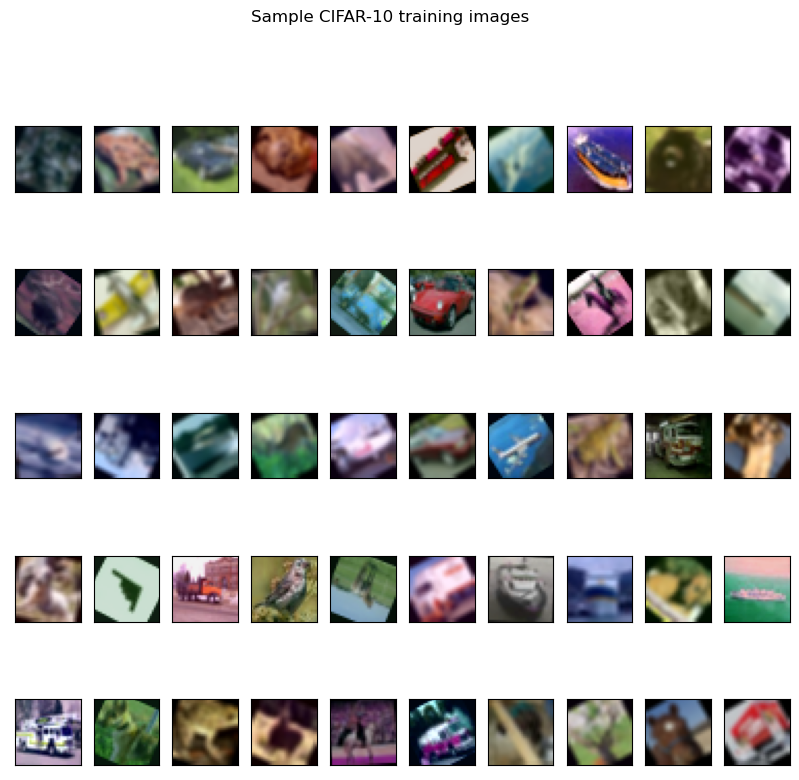

In [18]:
# Visualize 50 images from training set-
plt.figure(figsize = (10, 9))

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(images[i])
    # get current axes-
    ax = plt.gca()

    # hide x-axis-
    ax.get_xaxis().set_visible(False)

    # hide y-axis-
    ax.get_yaxis().set_visible(False)
    
plt.suptitle("Sample CIFAR-10 training images")
plt.show()

In [19]:
del images, labels

### ResNet-18 CNN

In [14]:
class ResNet_Block(nn.Module):
    '''
    VGG block within a VGG-* CNN model
    '''
    def __init__(
        self, num_inp_channels,
        num_channels, stride = 1,
        dropout = 0.2, use_1x1_conv = False
    ):
        super(ResNet_Block, self).__init__()
        
        self.num_inp_channels = num_inp_channels
        self.num_channels = num_channels
        self.stride = stride
        self.dropout = dropout
        self.use_1x1_conv = use_1x1_conv
    
        
        self.conv1 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = self.num_channels,
            kernel_size = 3, padding = 1,
            stride = self.stride, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.conv2 = nn.Conv2d(
            in_channels = self.num_channels, out_channels = self.num_channels,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn2 = nn.BatchNorm2d(num_features = self.num_channels)
        self.dropout = nn.Dropout(p = self.dropout)
        
        if self.use_1x1_conv:
            self.conv3 = nn.Conv2d(
            in_channels = self.num_inp_channels, out_channels = num_channels,
            kernel_size = 1, padding = 0,
            stride = self.stride, bias = False
            )
            self.bn3 = nn.BatchNorm2d(num_features = self.num_channels)
        
        self.initialize_weights()

            
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)

                '''
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                '''
            
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def forward(self, x):
        y = F.leaky_relu(self.bn1(self.conv1(x)))
        y = self.dropout(F.leaky_relu(self.bn2(self.conv2(y))))
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            
        y += x
        return F.leaky_relu(self.dropout(y))
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        y = (self.bn1(self.conv1(x)))
        print(f"First conv layer output shape: {y.shape}")
        y = self.bn2(self.conv2(y))
        print(f"Second conv layer output shape: {y.shape}")
        
        if self.use_1x1_conv:
            x = self.bn3(self.conv3(x))
            print(f"Downsample with S = 2; identity connection output shape: {x.shape}")
            
        y += x
        print(f"Residual block output shape: {y.shape}")
        return None
    

In [15]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels = 3, out_channels = 64,
            kernel_size = 3, padding = 1,
            stride = 1, bias = False
        )
        self.bn1 = nn.BatchNorm2d(num_features = 64)
        
        self.resblock1 = ResNet_Block(
            num_inp_channels = 64, num_channels = 64,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        self.resblock2 = ResNet_Block(
            num_inp_channels = 64, num_channels = 64,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        # Downsample-
        self.resblock3 = ResNet_Block(
            num_inp_channels = 64, num_channels = 128,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )
        
        self.resblock4 = ResNet_Block(
            num_inp_channels = 128, num_channels = 128,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        # Downsample-
        self.resblock5 = ResNet_Block(
            num_inp_channels = 128, num_channels = 256,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )

        self.resblock6 = ResNet_Block(
            num_inp_channels = 256, num_channels = 256,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )

        # Downsample-
        self.resblock7 = ResNet_Block(
            num_inp_channels = 256, num_channels = 512,
            stride = 2, dropout = 0.2,
            use_1x1_conv = True
        )

        self.resblock8 = ResNet_Block(
            num_inp_channels = 512, num_channels = 512,
            stride = 1, dropout = 0.2,
            use_1x1_conv = False
        )
        
        self.avg_pool = nn.AvgPool2d(kernel_size = 3, stride = 2)
        self.op_layer = nn.Linear(
            in_features = 512, out_features = 10,
            bias = True
        )
        
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)
        x = self.resblock6(x)
        x = self.resblock7(x)
        x = self.resblock8(x)
        x = self.avg_pool(x).squeeze()
        x = self.op_layer(x)
        return x
    

In [16]:
# Initialize ResNet-18 architecture-
model = ResNet18().to(device)

In [17]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([64, 3, 3, 3]) has 1728 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64, 64, 3, 3]) has 36864 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([64]) has 64 parameters
layer.shape = torch.Size([128, 64, 3, 3]) has 73728 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128]) has 128 parameters
layer.shape = torch.Size([128, 128, 3

In [18]:
print(f"Total number of parameters in ResNet-18 CNN = {tot_params}")

Total number of parameters in ResNet-18 CNN = 11173962


In [ ]:
'''
# Print layer names-
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].shape}")
'''

In [19]:
# Save random initial weights-
torch.save(model.state_dict(), 'ResNet18_random_weights.pth')

# Load randomly initialised weights-
# model.load_state_dict(torch.load('VGG18_random_weights_dropouts.pth'))

In [20]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0, momentum = 0.9, weight_decay = 5e-4)

#### Train model with learning rate scheduler

Training dataset = 50000, batch size = 256, number of training steps/iterations per epoch = 50000 / 256 = 195.3125 = 195

After an initial linear learning rate warmup of 13 epochs or 2539 training steps:

- For the next 32 epochs, or, 6250 steps - until 43rd epoch, use lr = 0.1.

- For the next 25 epochs, or, 4882 steps - until 68th epoch, use lr = 0.01.

- For remaining epochs (13 epochs), use lr = 0.001.

In [21]:
boundaries = [6250, 11132]
values = [0.1, 0.01, 0.001]

In [22]:
def decay_function(step, boundaries = [6250, 11132], values = [0.1, 0.01, 0.001]):
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]
    

In [23]:
class schedule():

    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+=self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(step)
        else:
            return self.current_lr


In [24]:
# Initial linear LR warmup: 195.3125 x 13 = 2549 steps in 13 epochs.
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 2539,
    decay_func = decay_function
)

In [25]:
step = 0

In [26]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


In [27]:
def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Set model to evaluation mode-
                model.eval()
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()


In [28]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler = {}

# Initialize parameters saving 'best' models-
best_val_loss = 100
# loc_patience = 0

In [29]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    val_loss, val_acc = test_model_progress(
        model = model, test_loader = val_loader,
        test_dataset = val_dataset
    )
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_loss < best_val_loss):    
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "ResNet18_best_model.pth")
        

Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.13batch/s, val_acc=11.7, val_loss=2.72]



epoch: 1 training loss = 2.2703, training accuracy = 14.65%, val_loss = 2.7158, val_accuracy = 11.73% & LR = 0.0077

Saving model with lowest val_loss = 2.7158



Validation: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00, 10.00batch/s, val_acc=14, val_loss=3.04]



epoch: 2 training loss = 2.0607, training accuracy = 23.27%, val_loss = 3.0362, val_accuracy = 13.96% & LR = 0.0154



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.11batch/s, val_acc=27.9, val_loss=2.17]



epoch: 3 training loss = 1.8851, training accuracy = 30.30%, val_loss = 2.1740, val_accuracy = 27.94% & LR = 0.0231

Saving model with lowest val_loss = 2.1740



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.14batch/s, val_acc=30.4, val_loss=2.16]



epoch: 4 training loss = 1.7451, training accuracy = 35.84%, val_loss = 2.1552, val_accuracy = 30.42% & LR = 0.0308

Saving model with lowest val_loss = 2.1552



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.24batch/s, val_acc=44.7, val_loss=1.59]



epoch: 5 training loss = 1.6581, training accuracy = 39.77%, val_loss = 1.5921, val_accuracy = 44.71% & LR = 0.0386

Saving model with lowest val_loss = 1.5921



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.26batch/s, val_acc=25.8, val_loss=2.93]



epoch: 6 training loss = 1.5774, training accuracy = 42.82%, val_loss = 2.9314, val_accuracy = 25.76% & LR = 0.0463



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.18batch/s, val_acc=37.7, val_loss=2.09]



epoch: 7 training loss = 1.4939, training accuracy = 46.16%, val_loss = 2.0937, val_accuracy = 37.66% & LR = 0.0540



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.18batch/s, val_acc=51.3, val_loss=1.49]



epoch: 8 training loss = 1.4229, training accuracy = 49.01%, val_loss = 1.4944, val_accuracy = 51.32% & LR = 0.0617

Saving model with lowest val_loss = 1.4944



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.26batch/s, val_acc=51.4, val_loss=1.48]



epoch: 9 training loss = 1.3472, training accuracy = 51.88%, val_loss = 1.4757, val_accuracy = 51.42% & LR = 0.0694

Saving model with lowest val_loss = 1.4757



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.19batch/s, val_acc=45.2, val_loss=1.75]



epoch: 10 training loss = 1.2931, training accuracy = 54.01%, val_loss = 1.7543, val_accuracy = 45.18% & LR = 0.0772



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.21batch/s, val_acc=60.1, val_loss=1.18]



epoch: 11 training loss = 1.2280, training accuracy = 56.48%, val_loss = 1.1842, val_accuracy = 60.10% & LR = 0.0849

Saving model with lowest val_loss = 1.1842



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.18batch/s, val_acc=61.7, val_loss=1.13]



epoch: 12 training loss = 1.1695, training accuracy = 58.36%, val_loss = 1.1320, val_accuracy = 61.72% & LR = 0.0926

Saving model with lowest val_loss = 1.1320



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.17batch/s, val_acc=60.5, val_loss=1.29]



epoch: 13 training loss = 1.1141, training accuracy = 60.81%, val_loss = 1.2899, val_accuracy = 60.50% & LR = 0.1000



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  9.82batch/s, val_acc=62.1, val_loss=1.13]



epoch: 14 training loss = 1.0637, training accuracy = 62.62%, val_loss = 1.1269, val_accuracy = 62.12% & LR = 0.1000

Saving model with lowest val_loss = 1.1269



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.13batch/s, val_acc=66.5, val_loss=0.996]



epoch: 15 training loss = 1.0199, training accuracy = 64.32%, val_loss = 0.9965, val_accuracy = 66.47% & LR = 0.1000

Saving model with lowest val_loss = 0.9965



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.14batch/s, val_acc=65.4, val_loss=1.01]



epoch: 16 training loss = 0.9738, training accuracy = 66.15%, val_loss = 1.0082, val_accuracy = 65.39% & LR = 0.1000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.14batch/s, val_acc=73.9, val_loss=0.752]



epoch: 17 training loss = 0.9438, training accuracy = 66.93%, val_loss = 0.7525, val_accuracy = 73.88% & LR = 0.1000

Saving model with lowest val_loss = 0.7525



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.15batch/s, val_acc=76.1, val_loss=0.711]



epoch: 18 training loss = 0.9235, training accuracy = 67.88%, val_loss = 0.7107, val_accuracy = 76.13% & LR = 0.1000

Saving model with lowest val_loss = 0.7107



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.19batch/s, val_acc=75.9, val_loss=0.718]



epoch: 19 training loss = 0.8884, training accuracy = 69.08%, val_loss = 0.7185, val_accuracy = 75.91% & LR = 0.1000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.20batch/s, val_acc=71.9, val_loss=0.845]



epoch: 20 training loss = 0.8814, training accuracy = 69.24%, val_loss = 0.8448, val_accuracy = 71.94% & LR = 0.1000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.15batch/s, val_acc=73.7, val_loss=0.773]



epoch: 21 training loss = 0.8562, training accuracy = 70.15%, val_loss = 0.7726, val_accuracy = 73.66% & LR = 0.1000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.08batch/s, val_acc=77.8, val_loss=0.661]



epoch: 22 training loss = 0.8445, training accuracy = 70.77%, val_loss = 0.6611, val_accuracy = 77.79% & LR = 0.1000

Saving model with lowest val_loss = 0.6611



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.19batch/s, val_acc=77.7, val_loss=0.648]



epoch: 23 training loss = 0.8241, training accuracy = 71.38%, val_loss = 0.6480, val_accuracy = 77.70% & LR = 0.1000

Saving model with lowest val_loss = 0.6480



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.19batch/s, val_acc=76.9, val_loss=0.698]



epoch: 24 training loss = 0.8176, training accuracy = 71.30%, val_loss = 0.6977, val_accuracy = 76.91% & LR = 0.1000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.16batch/s, val_acc=73.6, val_loss=0.795]



epoch: 25 training loss = 0.8040, training accuracy = 72.07%, val_loss = 0.7951, val_accuracy = 73.58% & LR = 0.1000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.52batch/s, val_acc=74.9, val_loss=0.753]



epoch: 26 training loss = 0.7959, training accuracy = 72.26%, val_loss = 0.7530, val_accuracy = 74.94% & LR = 0.1000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.50batch/s, val_acc=79.5, val_loss=0.606]



epoch: 27 training loss = 0.7877, training accuracy = 72.54%, val_loss = 0.6057, val_accuracy = 79.47% & LR = 0.1000

Saving model with lowest val_loss = 0.6057



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.14batch/s, val_acc=76.8, val_loss=0.676]



epoch: 28 training loss = 0.7770, training accuracy = 73.14%, val_loss = 0.6761, val_accuracy = 76.75% & LR = 0.1000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.22batch/s, val_acc=73.8, val_loss=0.794]



epoch: 29 training loss = 0.7736, training accuracy = 73.05%, val_loss = 0.7944, val_accuracy = 73.75% & LR = 0.1000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.17batch/s, val_acc=75.4, val_loss=0.759]



epoch: 30 training loss = 0.7639, training accuracy = 73.50%, val_loss = 0.7594, val_accuracy = 75.38% & LR = 0.1000



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.13batch/s, val_acc=80.8, val_loss=0.569]



epoch: 31 training loss = 0.7561, training accuracy = 73.91%, val_loss = 0.5691, val_accuracy = 80.84% & LR = 0.1000

Saving model with lowest val_loss = 0.5691



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.03batch/s, val_acc=83.7, val_loss=0.477]



epoch: 32 training loss = 0.7526, training accuracy = 74.03%, val_loss = 0.4766, val_accuracy = 83.69% & LR = 0.0100

Saving model with lowest val_loss = 0.4766



Validation: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.28batch/s, val_acc=86.4, val_loss=0.4]



epoch: 33 training loss = 0.6017, training accuracy = 79.16%, val_loss = 0.4002, val_accuracy = 86.44% & LR = 0.0100

Saving model with lowest val_loss = 0.4002



Validation: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.20batch/s, val_acc=87, val_loss=0.382]



epoch: 34 training loss = 0.5654, training accuracy = 80.30%, val_loss = 0.3821, val_accuracy = 87.02% & LR = 0.0100

Saving model with lowest val_loss = 0.3821



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  9.82batch/s, val_acc=87.2, val_loss=0.379]



epoch: 35 training loss = 0.5375, training accuracy = 81.28%, val_loss = 0.3794, val_accuracy = 87.22% & LR = 0.0100

Saving model with lowest val_loss = 0.3794



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.09batch/s, val_acc=87.5, val_loss=0.363]



epoch: 36 training loss = 0.5255, training accuracy = 81.72%, val_loss = 0.3630, val_accuracy = 87.50% & LR = 0.0100

Saving model with lowest val_loss = 0.3630



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.20batch/s, val_acc=88.2, val_loss=0.346]



epoch: 37 training loss = 0.5167, training accuracy = 81.87%, val_loss = 0.3462, val_accuracy = 88.19% & LR = 0.0100

Saving model with lowest val_loss = 0.3462



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.10batch/s, val_acc=87.7, val_loss=0.366]



epoch: 38 training loss = 0.5031, training accuracy = 82.63%, val_loss = 0.3662, val_accuracy = 87.74% & LR = 0.0100



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.35batch/s, val_acc=87.8, val_loss=0.356]



epoch: 39 training loss = 0.4991, training accuracy = 82.62%, val_loss = 0.3556, val_accuracy = 87.75% & LR = 0.0100



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.21batch/s, val_acc=88.4, val_loss=0.343]



epoch: 40 training loss = 0.4941, training accuracy = 82.70%, val_loss = 0.3431, val_accuracy = 88.45% & LR = 0.0100

Saving model with lowest val_loss = 0.3431



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.10batch/s, val_acc=88.4, val_loss=0.346]



epoch: 41 training loss = 0.4868, training accuracy = 82.99%, val_loss = 0.3458, val_accuracy = 88.44% & LR = 0.0100



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.36batch/s, val_acc=88.2, val_loss=0.349]



epoch: 42 training loss = 0.4759, training accuracy = 83.49%, val_loss = 0.3486, val_accuracy = 88.23% & LR = 0.0100



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.08batch/s, val_acc=88.6, val_loss=0.341]



epoch: 43 training loss = 0.4751, training accuracy = 83.48%, val_loss = 0.3410, val_accuracy = 88.59% & LR = 0.0100

Saving model with lowest val_loss = 0.3410



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.18batch/s, val_acc=88.7, val_loss=0.333]



epoch: 44 training loss = 0.4675, training accuracy = 83.67%, val_loss = 0.3332, val_accuracy = 88.67% & LR = 0.0100

Saving model with lowest val_loss = 0.3332



Validation: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.08batch/s, val_acc=89, val_loss=0.33]



epoch: 45 training loss = 0.4624, training accuracy = 83.75%, val_loss = 0.3299, val_accuracy = 88.97% & LR = 0.0100

Saving model with lowest val_loss = 0.3299



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  9.91batch/s, val_acc=88.5, val_loss=0.336]



epoch: 46 training loss = 0.4595, training accuracy = 83.89%, val_loss = 0.3362, val_accuracy = 88.46% & LR = 0.0100



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.18batch/s, val_acc=88.8, val_loss=0.329]



epoch: 47 training loss = 0.4534, training accuracy = 84.26%, val_loss = 0.3291, val_accuracy = 88.81% & LR = 0.0100

Saving model with lowest val_loss = 0.3291



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.31batch/s, val_acc=88.8, val_loss=0.339]



epoch: 48 training loss = 0.4490, training accuracy = 84.49%, val_loss = 0.3385, val_accuracy = 88.80% & LR = 0.0100



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.21batch/s, val_acc=89.2, val_loss=0.32]



epoch: 49 training loss = 0.4455, training accuracy = 84.38%, val_loss = 0.3198, val_accuracy = 89.17% & LR = 0.0100

Saving model with lowest val_loss = 0.3198



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.12batch/s, val_acc=89.3, val_loss=0.318]



epoch: 50 training loss = 0.4414, training accuracy = 84.54%, val_loss = 0.3182, val_accuracy = 89.26% & LR = 0.0100

Saving model with lowest val_loss = 0.3182



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  9.56batch/s, val_acc=89.1, val_loss=0.332]



epoch: 51 training loss = 0.4394, training accuracy = 84.71%, val_loss = 0.3317, val_accuracy = 89.07% & LR = 0.0100



Validation: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.13batch/s, val_acc=89, val_loss=0.32]



epoch: 52 training loss = 0.4344, training accuracy = 84.99%, val_loss = 0.3205, val_accuracy = 89.04% & LR = 0.0100



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.24batch/s, val_acc=89.6, val_loss=0.31]



epoch: 53 training loss = 0.4298, training accuracy = 85.04%, val_loss = 0.3098, val_accuracy = 89.56% & LR = 0.0100

Saving model with lowest val_loss = 0.3098



Validation: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.22batch/s, val_acc=89, val_loss=0.332]



epoch: 54 training loss = 0.4253, training accuracy = 85.16%, val_loss = 0.3323, val_accuracy = 89.02% & LR = 0.0100



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.17batch/s, val_acc=89.8, val_loss=0.307]



epoch: 55 training loss = 0.4230, training accuracy = 85.20%, val_loss = 0.3065, val_accuracy = 89.85% & LR = 0.0100

Saving model with lowest val_loss = 0.3065



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.17batch/s, val_acc=90.1, val_loss=0.304]



epoch: 56 training loss = 0.4216, training accuracy = 85.42%, val_loss = 0.3038, val_accuracy = 90.06% & LR = 0.0100

Saving model with lowest val_loss = 0.3038



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  9.95batch/s, val_acc=90.5, val_loss=0.283]



epoch: 57 training loss = 0.4156, training accuracy = 85.44%, val_loss = 0.2833, val_accuracy = 90.50% & LR = 0.0010

Saving model with lowest val_loss = 0.2833



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.19batch/s, val_acc=90.7, val_loss=0.278]



epoch: 58 training loss = 0.3825, training accuracy = 86.66%, val_loss = 0.2780, val_accuracy = 90.67% & LR = 0.0010

Saving model with lowest val_loss = 0.2780



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.13batch/s, val_acc=90.7, val_loss=0.276]



epoch: 59 training loss = 0.3802, training accuracy = 86.86%, val_loss = 0.2756, val_accuracy = 90.74% & LR = 0.0010

Saving model with lowest val_loss = 0.2756



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.09batch/s, val_acc=90.8, val_loss=0.272]



epoch: 60 training loss = 0.3743, training accuracy = 86.94%, val_loss = 0.2718, val_accuracy = 90.81% & LR = 0.0010

Saving model with lowest val_loss = 0.2718



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.13batch/s, val_acc=90.9, val_loss=0.272]



epoch: 61 training loss = 0.3667, training accuracy = 87.28%, val_loss = 0.2720, val_accuracy = 90.94% & LR = 0.0010



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.06batch/s, val_acc=90.8, val_loss=0.275]



epoch: 62 training loss = 0.3661, training accuracy = 87.22%, val_loss = 0.2746, val_accuracy = 90.79% & LR = 0.0010



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.08batch/s, val_acc=91.1, val_loss=0.267]



epoch: 63 training loss = 0.3640, training accuracy = 87.39%, val_loss = 0.2671, val_accuracy = 91.07% & LR = 0.0010

Saving model with lowest val_loss = 0.2671



Validation: : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.23batch/s, val_acc=91, val_loss=0.27]



epoch: 64 training loss = 0.3588, training accuracy = 87.49%, val_loss = 0.2696, val_accuracy = 90.95% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.26batch/s, val_acc=91, val_loss=0.269]



epoch: 65 training loss = 0.3578, training accuracy = 87.61%, val_loss = 0.2691, val_accuracy = 90.96% & LR = 0.0010



Validation: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.16batch/s, val_acc=91, val_loss=0.266]



epoch: 66 training loss = 0.3590, training accuracy = 87.35%, val_loss = 0.2658, val_accuracy = 91.01% & LR = 0.0010

Saving model with lowest val_loss = 0.2658



Validation: : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.35batch/s, val_acc=91, val_loss=0.266]



epoch: 67 training loss = 0.3502, training accuracy = 87.79%, val_loss = 0.2661, val_accuracy = 90.96% & LR = 0.0010



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.23batch/s, val_acc=91.1, val_loss=0.265]



epoch: 68 training loss = 0.3573, training accuracy = 87.59%, val_loss = 0.2647, val_accuracy = 91.14% & LR = 0.0010

Saving model with lowest val_loss = 0.2647



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.25batch/s, val_acc=91.2, val_loss=0.268]



epoch: 69 training loss = 0.3550, training accuracy = 87.51%, val_loss = 0.2680, val_accuracy = 91.18% & LR = 0.0010



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.16batch/s, val_acc=91.2, val_loss=0.267]



epoch: 70 training loss = 0.3482, training accuracy = 87.90%, val_loss = 0.2674, val_accuracy = 91.19% & LR = 0.0010



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.19batch/s, val_acc=91.1, val_loss=0.263]



epoch: 71 training loss = 0.3454, training accuracy = 87.90%, val_loss = 0.2629, val_accuracy = 91.13% & LR = 0.0010

Saving model with lowest val_loss = 0.2629



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.19batch/s, val_acc=91.3, val_loss=0.262]



epoch: 72 training loss = 0.3500, training accuracy = 87.72%, val_loss = 0.2617, val_accuracy = 91.32% & LR = 0.0010

Saving model with lowest val_loss = 0.2617



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.15batch/s, val_acc=91.3, val_loss=0.262]



epoch: 73 training loss = 0.3451, training accuracy = 87.99%, val_loss = 0.2619, val_accuracy = 91.29% & LR = 0.0010



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.18batch/s, val_acc=91.3, val_loss=0.262]



epoch: 74 training loss = 0.3448, training accuracy = 88.07%, val_loss = 0.2620, val_accuracy = 91.34% & LR = 0.0010



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.16batch/s, val_acc=91.3, val_loss=0.263]



epoch: 75 training loss = 0.3443, training accuracy = 88.04%, val_loss = 0.2627, val_accuracy = 91.27% & LR = 0.0010



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.34batch/s, val_acc=91.2, val_loss=0.261]



epoch: 76 training loss = 0.3465, training accuracy = 88.01%, val_loss = 0.2609, val_accuracy = 91.16% & LR = 0.0010

Saving model with lowest val_loss = 0.2609



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.38batch/s, val_acc=91.1, val_loss=0.264]



epoch: 77 training loss = 0.3408, training accuracy = 88.08%, val_loss = 0.2635, val_accuracy = 91.11% & LR = 0.0010



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.38batch/s, val_acc=91.2, val_loss=0.261]



epoch: 78 training loss = 0.3424, training accuracy = 88.16%, val_loss = 0.2615, val_accuracy = 91.20% & LR = 0.0010



Validation: : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.40batch/s, val_acc=91.2, val_loss=0.262]



epoch: 79 training loss = 0.3373, training accuracy = 88.23%, val_loss = 0.2622, val_accuracy = 91.17% & LR = 0.0010



Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.38batch/s, val_acc=91.3, val_loss=0.26]



epoch: 80 training loss = 0.3355, training accuracy = 88.40%, val_loss = 0.2602, val_accuracy = 91.31% & LR = 0.0010

Saving model with lowest val_loss = 0.2602



In [30]:
# Save model from last training epoch-
torch.save(model.state_dict(), "ResNet18_last_epoch_model.pth")

In [31]:
# Save training metrics as Python3 history for later analysis-
with open("ResNet18_training_history_lr_scheduler.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

In [32]:
del model

In [33]:
# Initialize and load 'best' trained parameters from above-
best_trained_model = ResNet18().to(device)
best_trained_model.load_state_dict(torch.load('ResNet18_best_model.pth'))

<All keys matched successfully>

In [36]:
# Get validation loss and accuracy-
val_loss, val_acc = test_model_progress(
    model = best_trained_model, test_loader = val_loader,
    test_dataset = val_dataset
)
print(f"ResNet-18 'best' model metrics: val_loss = {val_loss:.4f} & val_acc = {val_acc:.2f}%")

Validation: : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.67batch/s, val_acc=91.3, val_loss=0.26]

ResNet-18 'best' model metrics: val_loss = 0.2602 & val_acc = 91.31%


In [37]:
del best_trained_model

##### NOTE

It seems that the applied augmentations are a little excessive which might account for a low validation accuracy. In past, ResNet-18 using ```torchvision``` augmentations resulted in 93-ish % validation accuracy.

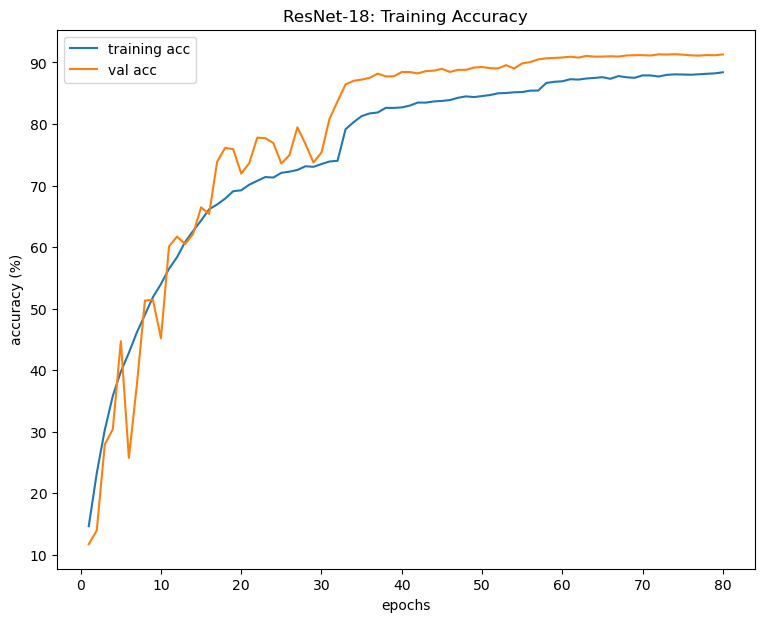

In [38]:
# Visualize ResNet-training-
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("ResNet-18: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

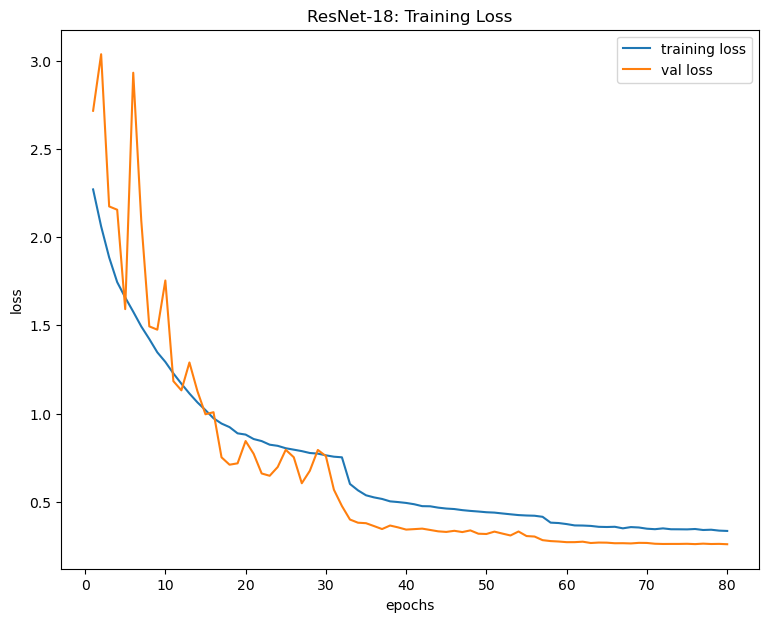

In [39]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("ResNet-18: Training Loss")
plt.show()

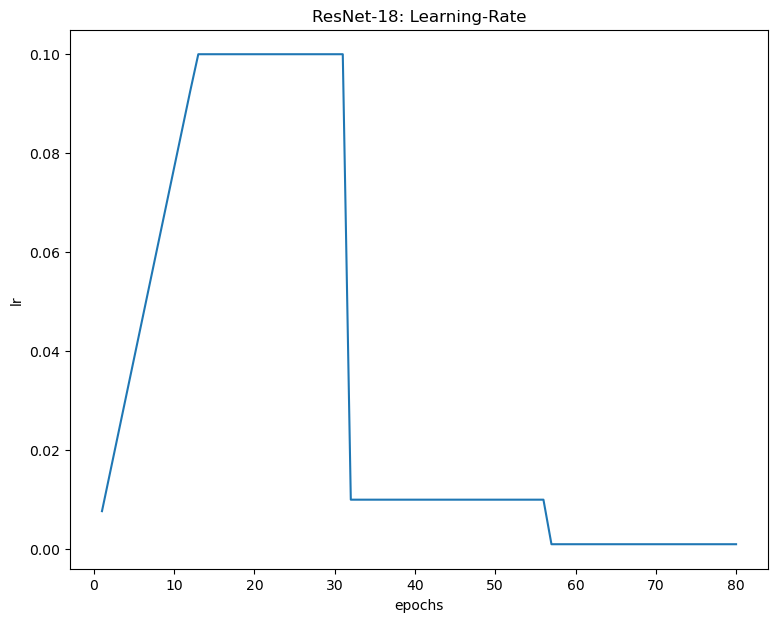

In [40]:
plt.figure(figsize = (9, 7))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("ResNet-18: Learning-Rate")
plt.show()